### Unsupervised Learning
- Clustering
    - K-Means Clustering
    - Hierarchical Clustering
- Performance Evaluation Techniques
    - Silhouette Score
    - Davies-Boulding Index - DBI


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Clustering

- When you need to group similar data points without labeled outputs.
- Useful for exploratory analysis, customer segmentation, anomaly detection, etc.
- Works well when patterns or natural groupings exist in the data.

<table border="1"> <tr> <th>Pros</th> <th>Cons</th> </tr> <tr> <td>Unsupervised → no need for labeled data.</td> <td>Results may vary with initialization (e.g., K-Means clustering).</td> </tr> <tr> <td>Helps discover hidden structures/patterns in data.</td> <td>Choosing the right number of clusters can be challenging.</td> </tr> <tr> <td>Applicable in many domains → marketing, biology, image analysis, anomaly detection.</td> <td>Cluster boundaries may be unclear when data overlaps.</td> </tr> <tr> <td>Scalable methods exist for large datasets.</td> <td>Sensitive to noise and outliers → can distort clusters.</td> </tr> <tr> <td>Can be combined with dimensionality reduction for better insights.</td> <td>Interpretability may be limited → clusters don't always have clear meaning.</td> </tr> </table>


#### K-Means Clustering
- Works best when clusters are roughly equally sized, and well separated.
- Simple, fast, and easy to implement and works well as a preprocessing step for other algorithms.
- However, requires the number of clusters (k) to be specified in advance.
- Sensitive to initialization (can converge to local minima).
- Affected by outliers and noise, which can distort centroids.


In [1]:
# K-Means Clustering with Elbow Method
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Load and prepare dataset
# -----------------------------
# Load car price dataset
df = pd.read_csv('primary_features_boolean_converted_final.csv')
df = df.dropna(subset=['price(Georgian Lari)'])  # Remove rows with missing target

# Feature engineering - create meaningful features for clustering
df['vehicle_age'] = 2024 - df['product_year']  # Age affects value and condition
df['luxury_score'] = df[['engine_volume', 'cylinders', 'airbags']].sum(axis=1)  # Luxury indicators
df['safety_score'] = df[['airbags', 'ABS', 'ESP', 'Central Locking', 'Alarm System']].sum(axis=1)  # Safety features

# Select numerical features for clustering
numerical_features = ['vehicle_age', 'luxury_score', 'safety_score', 'mileage', 'engine_volume', 'price(Georgian Lari)']
X = df[numerical_features].fillna(0)  # Fill missing values with 0

# Sample data for faster computation (especially for clustering)
# Using sample for faster computation while maintaining representativeness
SAMPLE_SIZE = 1500  # Adjust based on your dataset size
if len(X) > SAMPLE_SIZE:
    X_sample = X.sample(n=min(SAMPLE_SIZE, len(X)), random_state=42)
    print(f"Sampling {len(X_sample)} samples from {len(X)} total samples for faster computation")
else:
    X_sample = X
    print(f"Using full dataset: {len(X_sample)} samples")

# Standardize features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

print(f"Dataset shape: {X_scaled.shape}")
print(f"Features: {numerical_features}")


Sampling 1500 samples from 122478 total samples for faster computation
Dataset shape: (1500, 6)
Features: ['vehicle_age', 'luxury_score', 'safety_score', 'mileage', 'engine_volume', 'price(Georgian Lari)']


d:\Program Files\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Program Files\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "d:\Program Files\Anaconda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Program Files\Anaconda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

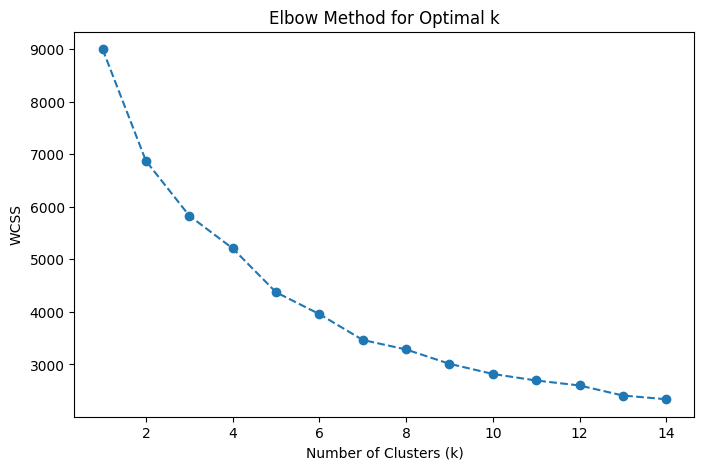

In [2]:
# -----------------------------
# 2. Elbow Method to find optimal k - The Elbow Method is one of the most popular techniques to determine the optimal number of clusters (k) in K-Means clustering.
# -----------------------------
wcss = []  # Within-Cluster Sum of Squares. Also called Inertia in scikit-learn.

for k in range(1, 15):              # Try k = 1 to 15. We test multiple values because the best k is not known in advance.
    kmeans = KMeans(
        n_clusters=k, 
        init="k-means++",           # centroid initialization method that speeds up convergence and avoids poor clustering results. [random, forgy, random_partition, etc.]
        random_state=42
    )
    kmeans.fit(X_scaled)                   # Fits the KMeans model on the dataset X (learns the cluster centroids)
    wcss.append(kmeans.inertia_)    # Inertia = WCSS. scikit-learn's attribute that stores the final WCSS for the fitted clustering model.

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()


d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


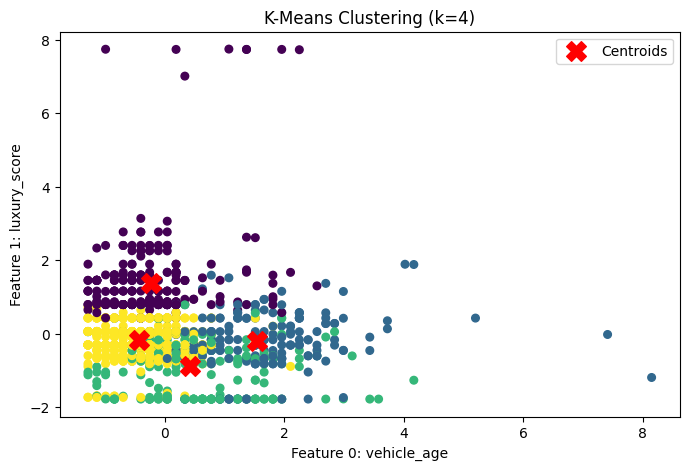


Cluster sizes:
Cluster 0: 280 samples (18.7%)
Cluster 1: 201 samples (13.4%)
Cluster 2: 224 samples (14.9%)
Cluster 3: 795 samples (53.0%)


In [3]:
# -----------------------------
# 3. Fit KMeans with optimal k
# -----------------------------
optimal_k = 4  # From elbow curve (pick after visual inspection) - adjust based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled) # fit_predict(X) both trains the model and tells you which cluster each point belongs to. y_kmeans is basically the map of data points to clusters.

# -----------------------------
# Visualize Clusters (using first 2 features for 2D visualization)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=30, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.xlabel(f"Feature 0: {numerical_features[0]}")
plt.ylabel(f"Feature 1: {numerical_features[1]}")
plt.legend()
plt.show()

# Print cluster information
print(f"\nCluster sizes:")
for i in range(optimal_k):
    cluster_size = np.sum(y_kmeans == i)
    print(f"Cluster {i}: {cluster_size} samples ({cluster_size/len(y_kmeans)*100:.1f}%)")


#### Hierarchical Clustering
- Does not require the number of clusters to be specified in advance.
- Suitable for small to medium-sized datasets; becomes computationally expensive for very large datasets.
- Can capture nested clusters and works well when clusters are not necessarily spherical.
- However, sensitive to noise and outliers, which can create misleading merges.


In [4]:
# Hierarchical Clustering Example
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Prepare dataset for hierarchical clustering
# -----------------------------
# Use a smaller sample for hierarchical clustering as it's computationally expensive
# Note: Make sure to run the K-Means section first to define X_sample
HIERARCHICAL_SAMPLE_SIZE = 500  # Smaller sample for faster computation

# If X_sample is not defined, reload and prepare data
if 'X_sample' not in globals():
    # Reload data if needed
    df_hc = pd.read_csv('primary_features_boolean_converted_final.csv')
    df_hc = df_hc.dropna(subset=['price(Georgian Lari)'])
    df_hc['vehicle_age'] = 2024 - df_hc['product_year']
    df_hc['luxury_score'] = df_hc[['engine_volume', 'cylinders', 'airbags']].sum(axis=1)
    df_hc['safety_score'] = df_hc[['airbags', 'ABS', 'ESP', 'Central Locking', 'Alarm System']].sum(axis=1)
    numerical_features_hc = ['vehicle_age', 'luxury_score', 'safety_score', 'mileage', 'engine_volume', 'price(Georgian Lari)']
    X_hc_full = df_hc[numerical_features_hc].fillna(0)
    X_sample_hc = X_hc_full.sample(n=min(HIERARCHICAL_SAMPLE_SIZE, len(X_hc_full)), random_state=42)
    X_hierarchical = X_sample_hc
    print(f"Sampling {len(X_hierarchical)} samples for hierarchical clustering")
else:
    if len(X_sample) > HIERARCHICAL_SAMPLE_SIZE:
        X_hierarchical = X_sample.sample(n=min(HIERARCHICAL_SAMPLE_SIZE, len(X_sample)), random_state=42)
        print(f"Sampling {len(X_hierarchical)} samples for hierarchical clustering")
    else:
        X_hierarchical = X_sample
        print(f"Using {len(X_hierarchical)} samples for hierarchical clustering")

# Standardize features
scaler_hc = StandardScaler()
X_hierarchical_scaled = scaler_hc.fit_transform(X_hierarchical)

print(f"Dataset shape for hierarchical clustering: {X_hierarchical_scaled.shape}")


Sampling 500 samples for hierarchical clustering
Dataset shape for hierarchical clustering: (500, 6)


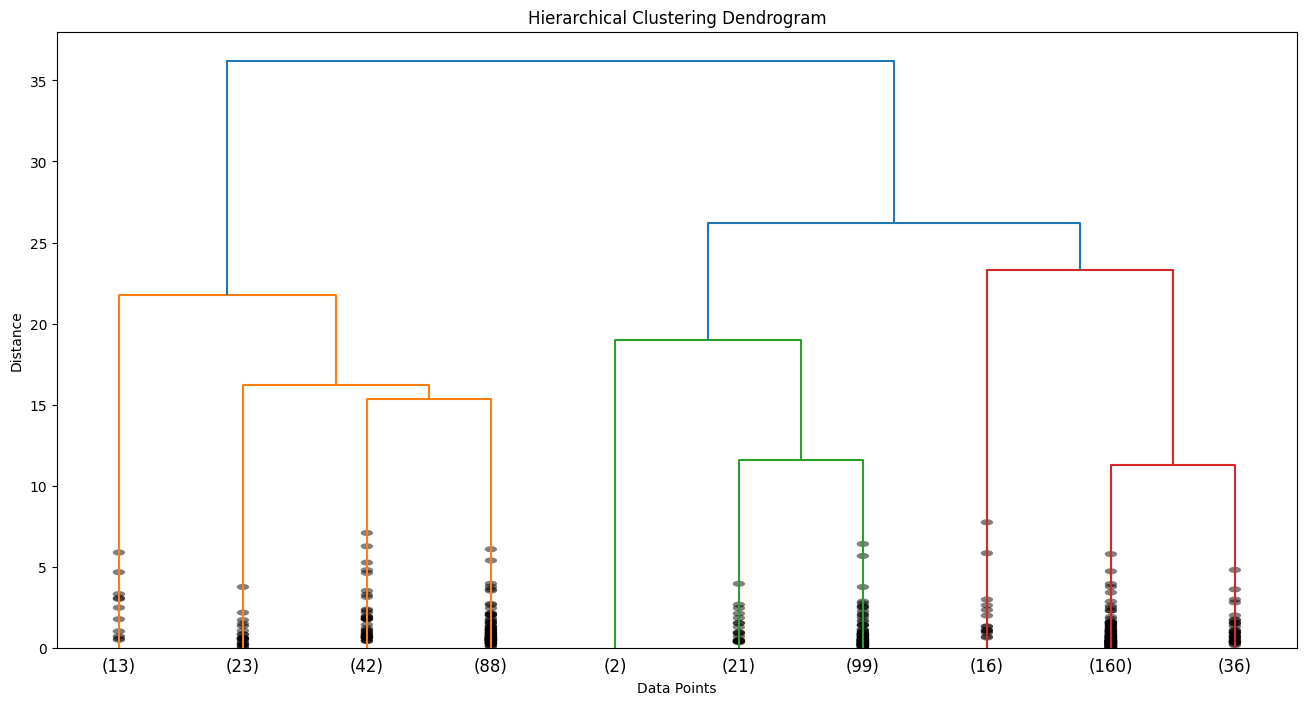

In [5]:
# -----------------------------
# 2. Plot Dendrogram - plots a tree diagram (dendrogram) that shows the hierarchy of clusters.
# -----------------------------
plt.figure(figsize=(16, 8))
linked = linkage(X_hierarchical_scaled, method="ward")  # calculates how to merge points/clusters step by step
dendrogram(linked, truncate_mode="lastp", p=10, show_contracted=True)  # 'lastp' shows the last p clusters
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


What it shows:
- X-axis: Data points (or clusters).
- Y-axis: Distance at which clusters are merged.
- Branches: Each branch represents a cluster merge.
- Height: Higher merge means clusters are more dissimilar.

Use:
- By cutting the dendrogram at a certain height, you can decide the number of clusters without specifying it in advance.
- Taller vertical lines indicate merges of very different clusters; short lines indicate merges of very similar clusters.


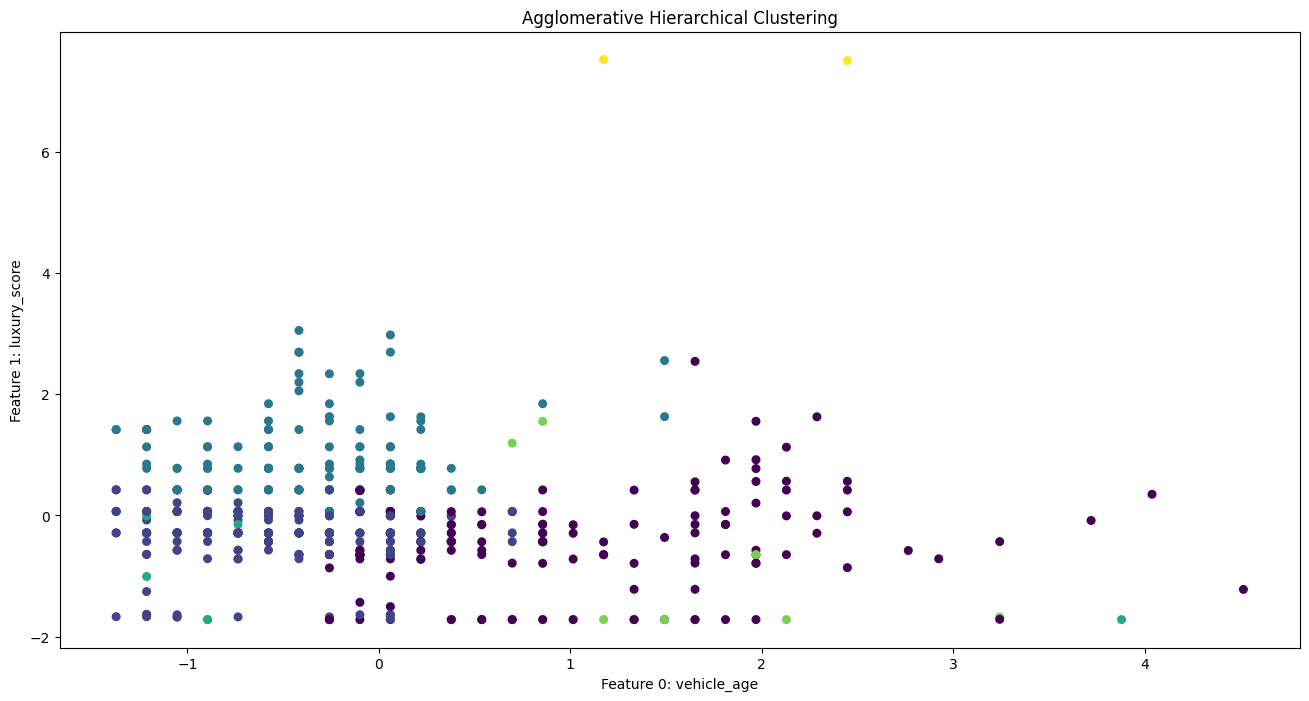


Cluster sizes:
Cluster 0: 153 samples (30.6%)
Cluster 1: 196 samples (39.2%)
Cluster 2: 120 samples (24.0%)
Cluster 3: 16 samples (3.2%)
Cluster 4: 13 samples (2.6%)
Cluster 5: 2 samples (0.4%)


In [6]:
# -----------------------------
# 3. Apply Agglomerative Clustering 
# -----------------------------
hc = AgglomerativeClustering( 
    n_clusters=6,  # Adjust based on dendrogram inspection
    metric="euclidean", 
    linkage="ward"
)
y_hc = hc.fit_predict(X_hierarchical_scaled)

# -----------------------------
# 4. Visualize Final Clusters
# -----------------------------
plt.figure(figsize=(16, 8))
plt.scatter(X_hierarchical_scaled[:, 0], X_hierarchical_scaled[:, 1], c=y_hc, cmap="viridis", s=30)
plt.title("Agglomerative Hierarchical Clustering")
# Use feature names if available, otherwise use generic labels
try:
    plt.xlabel(f"Feature 0: {numerical_features[0]}")
    plt.ylabel(f"Feature 1: {numerical_features[1]}")
except:
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
plt.show()

# Print cluster information
print(f"\nCluster sizes:")
for i in range(hc.n_clusters_):
    cluster_size = np.sum(y_hc == i)
    print(f"Cluster {i}: {cluster_size} samples ({cluster_size/len(y_hc)*100:.1f}%)")


What is Agglomerative Clustering?
- Agglomerative clustering is a type of hierarchical clustering.
    - Start: Treat each data point as its own cluster.
    - Merge: Iteratively merge the two closest clusters based on a distance metric.
    - Stop: Continue merging until you reach the desired number of clusters or a distance threshold.

- Distance between clusters can be calculated in different ways:
    - Single linkage: distance between the closest points
    - Complete linkage: distance between the farthest points
    - Average linkage: average distance between points in clusters
    - Ward's method: minimizes variance within clusters (default in scikit-learn)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Performace Evaluation of Unsupervised Learning Algorithms
- No single universal metric for unsupervised evaluation; use a combination of metrics.
- Internal metrics (Measures cluster quality based on the data itself) are most commonly used when ground truth is unavailable.
- Visualization and domain knowledge are essential for practical validation.


#### Silhouette Score
- Measures how well a data point fits within its own cluster compared to other clusters.
- Range: -1 to 1, where +1 indicates the point is well matched to its cluster, 0 indicates it lies near a cluster boundary, and -1 indicates possible misassignment to the wrong cluster.
- Intuitive and easy to interpret.
- Computationally heavy for very large datasets.
- Less reliable when clusters have different shapes, densities, or sizes.


Evaluating on dataset with shape: (1500, 6)
k=2, Average Silhouette Score=0.328
k=3, Average Silhouette Score=0.316


d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


k=4, Average Silhouette Score=0.291
k=5, Average Silhouette Score=0.254
k=6, Average Silhouette Score=0.265
k=7, Average Silhouette Score=0.274


d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

k=8, Average Silhouette Score=0.276
k=9, Average Silhouette Score=0.240
k=10, Average Silhouette Score=0.239


d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


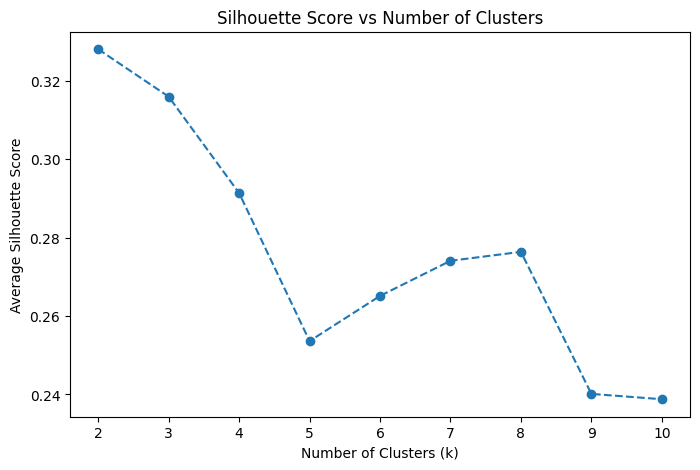

In [7]:
# Silhouette Score vs. Number of Clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Use the same dataset as K-Means
# -----------------------------
# Note: Make sure to run the K-Means section first to define X_scaled
# If X_scaled is not defined, reload and prepare data
if 'X_scaled' not in globals():
    # Reload data if needed
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    df_eval = pd.read_csv('primary_features_boolean_converted_final.csv')
    df_eval = df_eval.dropna(subset=['price(Georgian Lari)'])
    df_eval['vehicle_age'] = 2024 - df_eval['product_year']
    df_eval['luxury_score'] = df_eval[['engine_volume', 'cylinders', 'airbags']].sum(axis=1)
    df_eval['safety_score'] = df_eval[['airbags', 'ABS', 'ESP', 'Central Locking', 'Alarm System']].sum(axis=1)
    numerical_features_eval = ['vehicle_age', 'luxury_score', 'safety_score', 'mileage', 'engine_volume', 'price(Georgian Lari)']
    X_eval = df_eval[numerical_features_eval].fillna(0)
    X_sample_eval = X_eval.sample(n=min(1500, len(X_eval)), random_state=42)
    scaler_eval = StandardScaler()
    X_scaled = scaler_eval.fit_transform(X_sample_eval)

print(f"Evaluating on dataset with shape: {X_scaled.shape}")

# -----------------------------
# 2. Test multiple k values
# -----------------------------
k_values = range(2, 11)  # testing k = 2 to 10
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Average Silhouette Score={score:.3f}")

# -----------------------------
# 3. Plot silhouette score vs k
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.xticks(k_values)
plt.show()


#### Davies–Bouldin Index (DBI)
- Measures the average similarity between each cluster and its most similar cluster, considering both cluster scatter and separation.
- Lower values indicate better clustering, as clusters are more compact and well-separated.
- Computationally efficient and works for various cluster shapes.


Evaluating on dataset with shape: (1500, 6)
k=2, Davies–Bouldin Index=1.426
k=3, Davies–Bouldin Index=1.320
k=4, Davies–Bouldin Index=1.434
k=5, Davies–Bouldin Index=1.308
k=6, Davies–Bouldin Index=1.198
k=7, Davies–Bouldin Index=1.093
k=8, Davies–Bouldin Index=1.001
k=9, Davies–Bouldin Index=1.015
k=10, Davies–Bouldin Index=1.056


d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

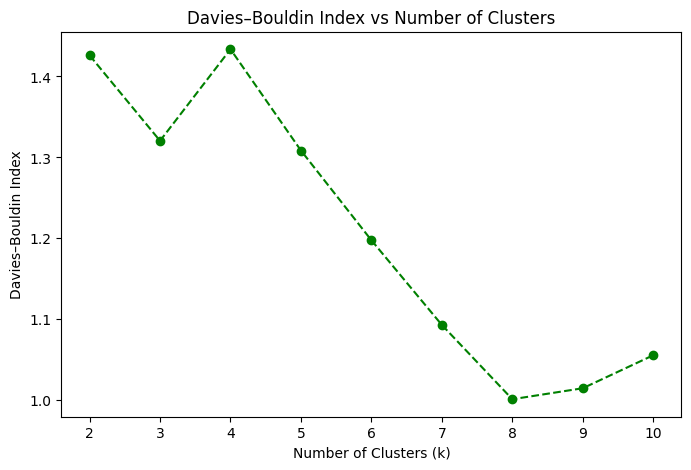

In [8]:
# Davies–Bouldin Index vs. Number of Clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# -----------------------------
# 1. Use the same dataset as K-Means
# -----------------------------
# Note: Make sure to run the K-Means section first to define X_scaled
# If X_scaled is not defined, reload and prepare data
if 'X_scaled' not in globals():
    # Reload data if needed
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    df_eval = pd.read_csv('primary_features_boolean_converted_final.csv')
    df_eval = df_eval.dropna(subset=['price(Georgian Lari)'])
    df_eval['vehicle_age'] = 2024 - df_eval['product_year']
    df_eval['luxury_score'] = df_eval[['engine_volume', 'cylinders', 'airbags']].sum(axis=1)
    df_eval['safety_score'] = df_eval[['airbags', 'ABS', 'ESP', 'Central Locking', 'Alarm System']].sum(axis=1)
    numerical_features_eval = ['vehicle_age', 'luxury_score', 'safety_score', 'mileage', 'engine_volume', 'price(Georgian Lari)']
    X_eval = df_eval[numerical_features_eval].fillna(0)
    X_sample_eval = X_eval.sample(n=min(1500, len(X_eval)), random_state=42)
    scaler_eval = StandardScaler()
    X_scaled = scaler_eval.fit_transform(X_sample_eval)

print(f"Evaluating on dataset with shape: {X_scaled.shape}")

# -----------------------------
# 2. Test multiple k values
# -----------------------------
k_values = range(2, 11)  # testing k = 2 to 10
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)
    print(f"k={k}, Davies–Bouldin Index={dbi:.3f}")

# -----------------------------
# 3. Plot DBI vs k
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(k_values, dbi_scores, marker="o", linestyle="--", color="green")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies–Bouldin Index")
plt.title("Davies–Bouldin Index vs Number of Clusters")
plt.xticks(k_values)
plt.show()
